In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker
import numpy as np
import random
import time
import os
import pandas as pd
import math
import bcolz
import pickle
import re

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
print("Pytorch: {}".format(torch.__version__))

Pytorch: 0.2.0_4


# Data loading

In [3]:
all_data_org = pd.read_csv('data/en_train_org.csv')

In [4]:
all_data_org[pd.isnull(all_data_org['before'])][:3]

,sentence_id,token_id,class,before,after
616107,49226,17,LETTERS,NaN,n a
684691,54634,1,PLAIN,NaN,NaN
965529,76612,7,PLAIN,NaN,NaN


In [5]:
all_data = all_data_org.dropna()
print("Data rows: {},  (dropped none rows: {})".format(len(all_data), len(all_data_org)-len(all_data)))
all_data = all_data[all_data['class'] != 'VERBATIM']
print("Data rows: {},  (dropped rows: {})".format(len(all_data), len(all_data_org)-len(all_data)))
all_data = all_data.reset_index(drop=True)

Data rows: 9918390,  (dropped none rows: 51)
Data rows: 9840282,  (dropped rows: 78159)


Note we dropped VERBATIM class. Thats because it had so many weird characters.

In [6]:
all_data_sentence_index = all_data.set_index('sentence_id')

### More balanced sample

In [7]:
all_data.groupby("class")["class"].count()

class
ADDRESS           522
CARDINAL       133744
DATE           258348
DECIMAL          9821
DIGIT            5442
ELECTRONIC       5162
FRACTION         1196
LETTERS        152790
MEASURE         14783
MONEY            6128
ORDINAL         12703
PLAIN         7353647
PUNCT         1880507
TELEPHONE        4024
TIME             1465
Name: class, dtype: int64

In [8]:
all_data_classes = list(all_data.groupby('class'))

In [9]:
def data_balance_randomize_classes(max_len=10000):
    global data_balanced_classes
    data_balanced_classes = pd.concat([v.sample(min(max_len, len(v))) for k, v in all_data_classes])

In [10]:
%time
data_balance_randomize_classes()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.44 µs


In [11]:
data_balanced_classes.groupby("class")["class"].count()

class
ADDRESS         522
CARDINAL      10000
DATE          10000
DECIMAL        9821
DIGIT          5442
ELECTRONIC     5162
FRACTION       1196
LETTERS       10000
MEASURE       10000
MONEY          6128
ORDINAL       10000
PLAIN         10000
PUNCT         10000
TELEPHONE      4024
TIME           1465
Name: class, dtype: int64

In [12]:
data_balanced_classes.sample(10)

,sentence_id,token_id,class,before,after
9258972,704501,8,ORDINAL,I,the first
5400589,415630,12,CARDINAL,257,two hundred fifty seven
3507210,272365,0,LETTERS,SRAP,s r a p
5023014,387117,5,DECIMAL,2.22,two point two two
6555626,502385,15,CARDINAL,4,four
3231976,251341,10,DIGIT,001,o o one
1460487,115597,18,CARDINAL,9,nine
669131,53869,1,CARDINAL,8,eight
448805,36291,8,LETTERS,B-,b
9165872,697591,5,DATE,1907,nineteen o seven


### Word vectors

In [13]:
def load_glove(name):
    with open(name, 'r') as f: lines = [line.split() for line in f]
    words = [d[0] for d in lines]
    vecs = np.stack(np.array(d[1:], dtype=np.float32) for d in lines)
    wordidx = {o:i for i,o in enumerate(words)}
    return vecs, words, wordidx

In [14]:
wv_vecs, wv_words, wv_idx = load_glove('/home/ohu/koodi/data/glove_wordvec/glove.6B.50d.txt')

In [15]:
re_apos = re.compile(r"(\w)'s\b")         # make 's a separate word
re_mw_punc = re.compile(r"(\w[’'])(\w)")  # other ' in a word creates 2 words
re_punc = re.compile("([\"().,;:/_?!—])") # add spaces around punctuation
re_mult_space = re.compile(r"  *")        # replace multiple spaces with just one

def simple_tokeniser(sent):
    sent = re_apos.sub(r"\1 's", sent)
    sent = re_mw_punc.sub(r"\1 \2", sent)
    sent = re_punc.sub(r" \1 ", sent).replace('-', ' - ')
    sent = re_punc.sub(r" \1 ", sent)
    sent = re_mult_space.sub(' ', sent)
    return sent.lower().split()
simple_tokeniser("asdf's   asdf   -testaaa")

['asdf', "'s", 'asdf', '-', 'testaaa']

arr = [simple_tokeniser(s_)[0] for s_ in list(all_data.sample(1000)['before'])]
[s in wv_idx for s in arr].count(True) / 1000

In [16]:
def get_random_sample():
    sample_row = data_balanced_classes.iloc[random.randint(1, len(data_balanced_classes)-1)]
    sentence_id = sample_row['class']

    #rows = all_data[all_data['sentence_id']==sample_row['sentence_id']]
    rows = all_data_sentence_index.loc[sample_row['sentence_id']]
    befores = rows.before.values
        
    token_id_idx = list(rows['token_id']).index(sample_row['token_id'])
    befores[token_id_idx] = '*****'
    str_list = simple_tokeniser(' '.join(befores))
    
    word_vect = np.zeros((1, len(str_list), wv_vecs.shape[1]), dtype=np.float32)
    # var = np.zeros((1, len(str_list), wv_vecs.shape[1]+1))
    for i, w in enumerate(str_list):
        if w=='*****':
            word_vect[0][i] = np.zeros((1, wv_vecs.shape[1]))
        else:
            try:
                word_vect[0][i] = wv_vecs[wv_idx[w]]
            except KeyError:
                word_vect[0][i] = np.random.rand(1, wv_vecs.shape[1])
    return sample_row['before'], sample_row['after'], sample_row['class'], word_vect
            
# get_random_sample()
s_bef, s_aft, s_class, s_word_v = get_random_sample()
print(s_class, ':', s_bef, '->', s_aft, ':', s_word_v.shape, type(s_word_v[0,0,0]))

LETTERS : D.A. -> d a : (1, 10, 50) <class 'numpy.float32'>


In [17]:
%%timeit
get_random_sample()

508 µs ± 26.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Categories and Chars

In [18]:
categories_all = all_data["class"].unique()
print(categories_all)
print(len(categories_all))
categories_index = dict((c, i) for i, c in enumerate(categories_all))

['PLAIN' 'PUNCT' 'DATE' 'LETTERS' 'CARDINAL' 'DECIMAL' 'MEASURE' 'MONEY'
 'ORDINAL' 'TIME' 'ELECTRONIC' 'DIGIT' 'FRACTION' 'TELEPHONE' 'ADDRESS']
15


In [19]:
letters_all = sorted(list(set(''.join(all_data['before']))))
letters_index = dict((c, i) for i, c in enumerate(letters_all))
letters_n = len(letters_all)
print(''.join(letters_all))
print(len(letters_all))

 !"#$%&'()+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]_abcdefghijklmnopqrstuvwxyz|~¡£¥ª«²³µº»¼½¾¿éɒʻˈΩμ—€⅓⅔⅛⅝⅞
112


In [20]:
def string_to_tensor(line):
    tensor = torch.zeros(1, len(line), letters_n)
    for li, letter in enumerate(line):
        tensor[0, li, letters_index[letter]] = 1
    return tensor
print(string_to_tensor('wordup').size())

torch.Size([1, 6, 112])


# Model functions

In [21]:
use_cuda = False

In [89]:
class RNN_WORDS_CHARS_CLASS(nn.Module):
    def __init__(self, wordvect_size, letters_size, hidden_size, output_size, words_layers=1, chars_layers=1):
        super(RNN_WORDS_CHARS_CLASS, self).__init__()

        self.train_iterations = 0
        self.train_history = []
        
        self.words_layers = words_layers
        self.chars_layers = chars_layers
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.rnn_words = nn.LSTM(wordvect_size, hidden_size // 2, words_layers,
                                 batch_first=True, bidirectional=True)

        self.rnn_chars = nn.LSTM(letters_size, hidden_size // 2, chars_layers,
                                batch_first=True, bidirectional=True)
        
        #self.lin_1 = nn.Linear(hidden_size*2, 1024)
        self.lin_output = nn.Linear(hidden_size*2, output_size)

    def forward(self, word_vectors, string_tensor, hidden = None, init_hidden = True):
        if init_hidden:
            hidden_words, hidden_chars = self.init_hidden()
        
        all_outputs_words, hidden_words = self.rnn_words(word_vectors, hidden_words)
        output_words = all_outputs_words[:, -1]
        
        all_outputs_chars, hidden_chars = self.rnn_chars(string_tensor, hidden_chars)
        output_chars = all_outputs_chars[:, -1]
        
        output = torch.cat((output_words, output_chars), 1)
        
        #output = self.lin_1(output)
        output = self.lin_output(output)
        output = F.log_softmax(output)
        return output

    def init_hidden(self):
        var1_1 = Variable(torch.zeros(2 * self.words_layers, 1, self.hidden_size // 2))
        var1_2 = Variable(torch.zeros(2 * self.words_layers, 1, self.hidden_size // 2))
        var2_1 = Variable(torch.zeros(2 * self.chars_layers, 1, self.hidden_size // 2))
        var2_2 = Variable(torch.zeros(2 * self.chars_layers, 1, self.hidden_size // 2))
        if use_cuda:
            var1_1 = var1_1.cuda(); var1_2 = var1_2.cuda()
            var2_1 = var2_1.cuda(); var2_2 = var2_2.cuda()
        return ((var1_1, var1_2), (var2_1, var2_2))

use_cuda = False
s_bef, s_aft, s_class, s_word_vs = get_random_sample()
s_string = string_to_tensor(s_bef)
model_tmp = RNN_WORDS_CHARS_CLASS(wordvect_size=s_word_vs.shape[-1], letters_size=letters_n,
                                  hidden_size=128, output_size=len(categories_all),
                                  words_layers=2, chars_layers=2)
print('Word vect size:', s_word_vs.shape, '. String vector size:', s_string.size())
output = model_tmp(Variable(torch.from_numpy(s_word_vs)), Variable(s_string))
print('Output:', output.size())
use_cuda = True

Word vect size: (1, 9, 50) . String vector size: torch.Size([1, 1, 112])
Output: torch.Size([1, 15])


tmp = use_cuda
use_cuda = True
model_tmp.cuda()
output = model_tmp(Variable(torch.from_numpy(s_word_vs)).cuda(), Variable(s_string).cuda())
use_cuda = tmp
type(output.data)

### Accuracy

In [23]:
def category_from_output(output):
    top_n, top_i = output.data.topk(1)
    category_i = top_i[0][0]
    return categories_all[category_i], category_i

print(category_from_output(output))

('LETTERS', 3)


In [24]:
def test_model_accuracy(model, n_sample=10000):
    model.eval()
    n_correct = 0
    for iteration in range(n_sample):
        s_bef, s_aft, s_class, s_word_vs = get_random_sample()
        s_string = Variable(string_to_tensor(s_bef))
        s_word_vs = Variable(torch.from_numpy(s_word_vs))
        if use_cuda:
            s_word_vs = s_word_vs.cuda()
            s_string = s_string.cuda()
        output = model(s_word_vs, s_string)
        if s_class == category_from_output(output)[0]:
            n_correct += 1

    print("Accuracy: {:>4.2%} ({:>8d}/{:>8d})".format(
            n_correct/n_sample, n_correct, n_sample))

%%time
test_model_accuracy(model_tmp.cuda(), n_sample=1000)

### Training

In [25]:
def train(model, category, word_vectors, string, loss_function, optimizer):
    category_tensor = Variable(torch.LongTensor([categories_index[category]]))
    word_vectors = Variable(torch.from_numpy(word_vectors))
    string = Variable(string_to_tensor(string))
    if use_cuda:
        category_tensor = category_tensor.cuda()
        word_vectors = word_vectors.cuda()
        string = string.cuda()

    output = model(word_vectors, string)
    loss = loss_function(output, category_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.data[0]

loss_function = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
s_bef, s_aft, s_class, s_word_vs = get_random_sample()
train(model, s_class, s_word_vs, s_bef)

In [26]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [27]:
def train_iterations(n_iters=100000, lr=0.001, print_every=20000, plot_every=1000):
    model.train()
    start = time.time()
    
    loss_function = nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    current_loss = 0
    current_loss_iter = 0

    for iteration in range(1, n_iters + 1):
        model.train_iterations += 1
        s_bef, s_aft, s_class, s_word_vs = get_random_sample()

        output, loss = train(model, s_class, s_word_vs, s_bef, loss_function, optimizer)
        current_loss += loss
        current_loss_iter += 1

        # Print iter number, loss, name and guess
        if iteration % print_every == 0:
            guess, guess_i = category_from_output(output)
            correct = '✓' if guess == s_class else "✗ ({})".format(s_class)
            print("{:>6d} {:>4.0%} ({:>8}) {:>7.3f}   | {:>6.2f}: {} -> {} {}".format(
                model.train_iterations, iteration/n_iters, timeSince(start),
                current_loss/current_loss_iter, loss,
                s_bef, guess, correct ))

        # Add current loss avg to list of losses
        if iteration % plot_every == 0:
            model.train_history.append((current_loss / plot_every, lr))
            current_loss = 0
            current_loss_iter = 0
            
        if iteration % 50000 == 0:
            data_balance_randomize_classes()
    
    test_model_accuracy(model, n_sample=10000)

# Model testing

In [90]:
model = RNN_WORDS_CHARS_CLASS(wordvect_size=s_word_vs.shape[-1], letters_size=letters_n,
                              hidden_size=128, output_size=len(categories_all),
                              words_layers=2, chars_layers=2).cuda()

In [91]:
train_iterations(n_iters=100000)

 20000  20% (  2m 51s)   0.185   |   0.08: 3 -> CARDINAL ✓
 40000  40% (  5m 37s)   0.141   |   0.01: the -> PLAIN ✓
 60000  60% (  8m 27s)   0.117   |   0.00: 50 percent -> MEASURE ✓
 80000  80% ( 11m 20s)   0.118   |   0.01: Tottenham -> PLAIN ✓
100000 100% ( 14m 17s)   0.114   |   0.00: , -> PUNCT ✓
Accuracy: 97.12% (    9712/   10000)


In [92]:
train_iterations(n_iters=200000)

120000  10% (  2m 56s)   0.059   |   0.00: .69 -> DECIMAL ✓
140000  20% (  5m 48s)   0.086   |   0.00: 1860 -> DATE ✓
160000  30% (  8m 41s)   0.065   |   0.03: 538 -> CARDINAL ✓
180000  40% ( 11m 29s)   0.096   |   0.01: DDR -> LETTERS ✓
200000  50% ( 14m 18s)   0.084   |   0.00: September 19, 2014 -> DATE ✓
220000  60% (  17m 6s)   0.045   |   0.00: BBC.co.uk -> ELECTRONIC ✓
240000  70% ( 19m 53s)   0.060   |   0.00: IAF's -> LETTERS ✓
260000  80% ( 22m 47s)   0.074   |   0.00: 828.7 -> DECIMAL ✓
280000  90% ( 25m 37s)   0.041   |   0.00: 1 -> CARDINAL ✓
300000 100% ( 28m 27s)   0.058   |   0.00: .44 -> DECIMAL ✓
Accuracy: 98.15% (    9815/   10000)


In [93]:
train_iterations(n_iters=200000, lr=0.0001)

320000  10% (  2m 50s)   0.067   |   0.00: 76% -> MEASURE ✓
340000  20% (  5m 45s)   0.047   |   0.00: 15.2 -> DECIMAL ✓
360000  30% (  8m 36s)   0.043   |   0.00: 6 km -> MEASURE ✓
380000  40% ( 11m 24s)   0.021   |   0.02: 4 -> DIGIT ✓
400000  50% (  14m 9s)   0.034   |   0.00: 65th -> ORDINAL ✓
420000  60% ( 16m 54s)   0.055   |   0.00: . -> PUNCT ✓
440000  70% ( 19m 37s)   0.038   |   0.00: 9.287 -> DECIMAL ✓
460000  80% ( 22m 32s)   0.029   |   0.00: Rachel -> PLAIN ✓
480000  90% ( 25m 27s)   0.057   |   0.01: 3 -> DIGIT ✓
500000 100% ( 28m 20s)   0.034   |   0.00: 34.3 m -> MEASURE ✓
Accuracy: 98.51% (    9851/   10000)


In [100]:
train_iterations(n_iters=200000, lr=0.0001)

520000  10% (  2m 40s)   0.045   |   0.00: expenses -> PLAIN ✓
540000  20% (  5m 19s)   0.045   |   0.00: in -> PLAIN ✓
560000  30% (   8m 0s)   0.031   |   0.27: 51 -> CARDINAL ✓
580000  40% ( 10m 41s)   0.047   |   0.01: 2000 -> DATE ✓
600000  50% ( 13m 23s)   0.040   |   0.00: 80% -> MEASURE ✓
620000  60% (  16m 3s)   0.049   |   0.00: . -> PUNCT ✓
640000  70% ( 18m 44s)   0.066   |   0.00: 11th -> ORDINAL ✓
660000  80% ( 21m 24s)   0.036   |   0.00: 645 km² -> MEASURE ✓
680000  90% (  24m 5s)   0.057   |   0.01: 50 -> CARDINAL ✓
700000 100% ( 26m 45s)   0.057   |   0.00: 250,000.00 -> DECIMAL ✓
Accuracy: 98.72% (    9872/   10000)


In [102]:
train_iterations(n_iters=400000, lr=0.00005)

720000   5% (  2m 42s)   0.028   |   0.00: £150k -> MONEY ✓
740000  10% (  5m 23s)   0.049   |   0.00: 1989 -> DATE ✓
760000  15% (   8m 4s)   0.042   |   0.00: 3.5 -> DECIMAL ✓
780000  20% ( 10m 47s)   0.035   |   0.00: 10th -> ORDINAL ✓
800000  25% ( 13m 27s)   0.032   |   0.00: May 1992 -> DATE ✓
820000  30% (  16m 8s)   0.032   |   0.00: valley -> PLAIN ✓
840000  35% ( 18m 50s)   0.039   |   0.00: $1 -> MONEY ✓
860000  40% ( 21m 31s)   0.039   |   0.00: surveyed -> PLAIN ✓
880000  45% ( 24m 12s)   0.048   |   0.00: US$20 million -> MONEY ✓
900000  50% ( 26m 52s)   0.043   |   0.08: 3 -> CARDINAL ✓
920000  55% ( 29m 34s)   0.030   |   0.00: 17.09 -> DECIMAL ✓
940000  60% ( 32m 16s)   0.040   |   0.00: 2003 -> DATE ✓
960000  65% ( 34m 58s)   0.035   |   0.00: " -> PUNCT ✓
980000  70% ( 37m 38s)   0.046   |   0.00: 480 -> CARDINAL ✓
1000000  75% ( 40m 19s)   0.049   |   0.00: ; -> PUNCT ✓
1020000  80% ( 42m 59s)   0.049   |   0.00: The -> PLAIN ✓
1040000  85% ( 45m 39s)   0.032   |   

In [103]:
train_iterations(n_iters=400000, lr=0.00005)

1120000   5% (  2m 40s)   0.051   |   0.00: 121 (2007) 753-758 -> TELEPHONE ✓
1140000  10% (  5m 20s)   0.038   |   0.01: 4 -> DIGIT ✓
1160000  15% (   8m 1s)   0.044   |   0.00: 20/15 -> FRACTION ✓
1180000  20% ( 10m 42s)   0.045   |   0.00: S.A. -> LETTERS ✓
1200000  25% ( 13m 23s)   0.035   |   0.00: $1 Million -> MONEY ✓
1220000  30% (  16m 5s)   0.031   |   0.00: 4% -> MEASURE ✓
1240000  35% ( 18m 45s)   0.042   |   0.00: http://psychcentral.com/lib/self-acceptance-is-the-key-to-a-healthier-self-image/00020766Schildbach -> ELECTRONIC ✓
1260000  40% ( 21m 26s)   0.044   |   0.00: cloned -> PLAIN ✓
1280000  45% (  24m 7s)   0.021   |   0.00: 500,000 -> CARDINAL ✓
1300000  50% ( 26m 49s)   0.023   |   0.00: in -> PLAIN ✓
1320000  55% ( 29m 30s)   0.045   |   0.00: 1:55:36 -> TIME ✓
1340000  60% ( 32m 11s)   0.031   |   0.00: November 6, 2014 -> DATE ✓
1360000  65% ( 34m 53s)   0.027   |   0.00: 20th -> ORDINAL ✓
1380000  70% ( 37m 34s)   0.039   |   0.00: 97.5 -> DECIMAL ✓
1400000  7

In [107]:
data_balance_randomize_classes(50000)
test_model_accuracy(model, n_sample=10000)

Accuracy: 98.18% (    9818/   10000)


### Results eval

In [113]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(len(categories_all), len(categories_all))
n_confusion = 100000
data_balance_randomize_classes(50000)

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    s_bef, s_aft, s_class, s_word_vs = get_random_sample()
    word_vectors = Variable(torch.from_numpy(s_word_vs))
    string = Variable(string_to_tensor(s_bef))
    if use_cuda:
        word_vectors = word_vectors.cuda()
        string = string.cuda()
    output = model(word_vectors, string)
    guess, guess_i = category_from_output(output)
    category_i = categories_index[s_class]
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(len(categories_all)):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + list(categories_all), rotation=90)
ax.set_yticklabels([''] + list(categories_all))

# Force label at every tick
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

KeyboardInterrupt: 

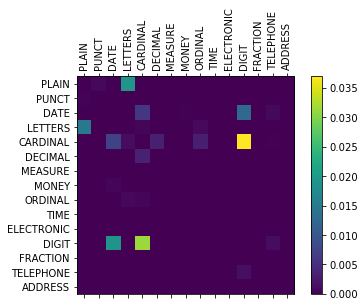

In [105]:
confusion_2 = confusion.clone().numpy()
for i in range(len(confusion_2)):
    confusion_2[i,i]=0

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_2)
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + list(categories_all), rotation=90)
ax.set_yticklabels([''] + list(categories_all))

# Force label at every tick
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

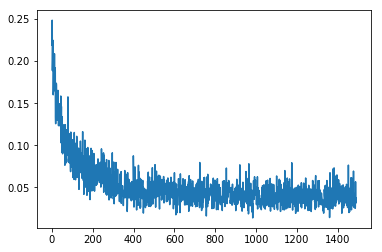

In [106]:
all_losses = [arr[0] for arr in model.train_history[10:]]
plt.figure()
plt.plot(all_losses)

# Saving the model

In [111]:
saved_model_path = 'data/models/category_rnn_bi_2_layer_' + str(model.train_iterations)
saved_model_path

'data/models/category_rnn_bi_2_layer_1500000'

In [112]:
torch.save(model.state_dict(), saved_model_path)